# Project B: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir(r'/content/drive/My Drive/ECE1512')
tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

Mounted at /content/drive


In [10]:
from tensorflow import keras
from keras.models import load_model
from tensorflow.keras import layers
#from keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# Data loading

In [3]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  class_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, class_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [5]:
mnist_train

<BatchDataset element_spec=(TensorSpec(shape=(256, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(256, 10), dtype=tf.float32, name=None))>

# Model creation

In [4]:
# Build CNN teacher.
#cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
teacher = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        layers.Conv2D(64, (3, 3), strides=(1, 1), padding="same"),
        layers.ReLU(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="same"),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(10)
    ],
    name="teacher",
)


# Build fully connected student.
#fc_model = tf.keras.Sequential()


# your code start from here for step 2

student = keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student",
)




# Teacher loss function

In [5]:

def compute_teacher_loss(images, labels,temperature,alpha):
  """Compute class knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  class_logits = teacher(images, training=True)

  # Compute cross-entropy loss for classes.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,class_logits))

  return cross_entropy_loss_value

# Student loss function

In [6]:
# Hyperparameters for distillation (need to be tuned).
# ALPHA = 0.5 # task balance between cross-entropy and distillation loss
# DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = teacher_logits / temperature
  soft_targets =tf.nn.softmax(soft_targets)
  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature))*temperature**2
  #* temperature ** 2

def compute_student_loss(images, labels,temperature,alpha):
  """Compute class knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_class_logits = student(images, training=True)

  # Compute class distillation loss between student class logits and
  # softened teacher class targets probabilities.

  # your code start from here for step 3

  teacher_class_logits = teacher(images, training=False)
  distillation_loss_value =distillation_loss(teacher_class_logits,student_class_logits,temperature)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

 
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))

  total_loss =alpha*cross_entropy_loss_value + (1-alpha)*distillation_loss_value

  return total_loss

# Train and evaluation

### TRAINING and EVALUATE FUNCTION

In [7]:
# your code start from here for step 5 

@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)
              
def train_and_evaluate(model, compute_loss_fn,temperature,learning_rate,alpha):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """
 
  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
          
          loss_value = compute_loss_fn(images,labels,temperature,alpha)

      grads = tape.gradient(loss_value, model.trainable_variables)
      # grads = [gradient*(1) for gradient in grads]
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      
    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
    #   # your code start from here for step 4

      num_correct += compute_num_correct(model,images,labels)[0]
      
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))


## **Training models**

In [8]:
temp=4
learning_rate=0.001
alpha=0.5
print("Teacher training")
train_and_evaluate(teacher, compute_teacher_loss,temp,learning_rate,alpha)

Teacher training
Epoch 1: Class_accuracy: 98.06%
Epoch 2: Class_accuracy: 98.50%
Epoch 3: Class_accuracy: 98.82%
Epoch 4: Class_accuracy: 98.95%
Epoch 5: Class_accuracy: 99.02%
Epoch 6: Class_accuracy: 99.07%
Epoch 7: Class_accuracy: 99.12%
Epoch 8: Class_accuracy: 99.24%
Epoch 9: Class_accuracy: 99.24%
Epoch 10: Class_accuracy: 99.13%
Epoch 11: Class_accuracy: 99.19%
Epoch 12: Class_accuracy: 99.22%


In [34]:
teacher.save("teacher_model.h5")
teacher.save_weights("teacher_model_weight")

In [10]:
learning_rate=0.001
alpha=0.5
print("Student distill training")
train_and_evaluate(student, compute_student_loss,temp,learning_rate,alpha)

Student distill training
Epoch 1: Class_accuracy: 96.86%
Epoch 2: Class_accuracy: 97.82%
Epoch 3: Class_accuracy: 98.15%
Epoch 4: Class_accuracy: 98.46%
Epoch 5: Class_accuracy: 98.50%
Epoch 6: Class_accuracy: 98.63%
Epoch 7: Class_accuracy: 98.73%
Epoch 8: Class_accuracy: 98.73%
Epoch 9: Class_accuracy: 98.85%
Epoch 10: Class_accuracy: 98.84%
Epoch 11: Class_accuracy: 98.89%
Epoch 12: Class_accuracy: 98.85%


In [36]:
student.save('student_kd_temp4.h5')
student.save_weights('student_kd_temp4_weight')

# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6


# Train student from scratch

In [12]:
# Build fully connected student.
# fc_model_no_distillation = tf.keras.Sequential()
student_no_distil = tf.keras.Sequential(
    [
        keras.Input(shape=(28, 28, 1)),
        layers.Flatten(),
        layers.Dense(784, activation="relu"),
        layers.Dense(784, activation="relu"),
        layers.Dense(10)

    ],
    name="student_no_distil",
)

In [13]:
student_no_distil.summary()

Model: "student_no_distil"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_5 (Dense)             (None, 784)               615440    
                                                                 
 dense_6 (Dense)             (None, 784)               615440    
                                                                 
 dense_7 (Dense)             (None, 10)                7850      
                                                                 
Total params: 1,238,730
Trainable params: 1,238,730
Non-trainable params: 0
_________________________________________________________________


In [14]:

# your code start from here for step 7
def compute_plain_cross_entropy_loss(images, labels, temperature,alpha):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over classes, but does not perform class distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7
  
  student_class_logits = student_no_distil(images, training=True)
  # cross_entropy_loss =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits))*temperature**2
  cross_entropy_loss =tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels, student_class_logits/temperature))*temperature**2

  return cross_entropy_loss




## TRAIN **STUDENT_NO_DISTILL** FROM SCRATCH

In [15]:
learning_rate=0.001
alpha=0.5
temp=4
print("Student without distill training")
train_and_evaluate(student_no_distil, compute_plain_cross_entropy_loss,temp,learning_rate,alpha)

Student without distill training
Epoch 1: Class_accuracy: 95.44%
Epoch 2: Class_accuracy: 96.80%
Epoch 3: Class_accuracy: 97.29%
Epoch 4: Class_accuracy: 97.68%
Epoch 5: Class_accuracy: 98.02%
Epoch 6: Class_accuracy: 97.95%
Epoch 7: Class_accuracy: 98.06%
Epoch 8: Class_accuracy: 98.10%
Epoch 9: Class_accuracy: 98.24%
Epoch 10: Class_accuracy: 97.93%
Epoch 11: Class_accuracy: 97.92%
Epoch 12: Class_accuracy: 97.88%


In [37]:
student_no_distil.save('student_wo_kd_temp4.h5')
student_no_distil.save_weights('student_wo_kd_temp4_weight')

In [ ]:
#train_and_evaluate(student, compute_plain_cross_entropy_loss)

# Comparing the teacher and student model (number of of parameters and FLOPs) 

In [ ]:
!pip install keras-flops

### LOAD Teacher model and weights during it's training

In [13]:
teacher_load=load_model('./teacher_model.h5')
teacher_load.load_weights('./teacher_model_weight')

### Teacher model FLOPS

In [27]:
# your code start from here for step 8
# Calculae FLOPS
from keras_flops import get_flops
flops = get_flops(teacher_load, batch_size=256)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 8.39 G


### Student model FLOPS

In [29]:
student_kd_load=load_model('./student_kd_temp4.h5')
student_kd_load.load_weights('./student_kd_temp4_weight')

In [30]:
flops = get_flops(student_kd_load, batch_size=256)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 0.634 G


### Student without KD model FLOPS

In [31]:
student_wo_kd_load=load_model('./student_wo_kd_temp4.h5')
student_wo_kd_load.load_weights('./student_wo_kd_temp4_weight')

In [32]:
flops = get_flops(student_wo_kd_load, batch_size=256)
print(f"FLOPS: {flops / 10 ** 9:.03} G")

FLOPS: 0.634 G


# XAI method to explain models

## PLOT DATASET

In [33]:
import matplotlib.pyplot as plt

In [34]:
mnist_xai = tfds.load('mnist', split='train')

In [35]:
# test_teach_model=load_model('./teacher_model.h5')

In [36]:

mnist_xai_procesd = mnist_xai.map(preprocess).batch(BATCH_SIZE)
# mnist_xai =mnist_xai.batch(BATCH_SIZE, drop_remainder=True)
# mnist_xai_procesd

In [37]:
mnist_xai_1,=mnist_xai_procesd.take(1)

In [38]:
x, y = mnist_xai_1

In [39]:
mnist_xai


<PrefetchDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [40]:
mnist_xai_procesd


<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
mnist_xai_1

In [42]:
x[0].shape

TensorShape([28, 28, 1])

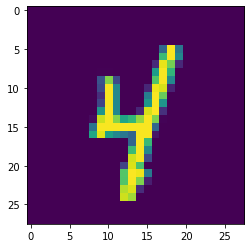

In [43]:
plt.imshow(tf.squeeze(x[0])) # squeeze removes dimension of size 1 like (28,28,1) -> (28,28)

## GET PREDICTION from TEACHER model for particular INPUT

In [25]:
pred=teacher_load(tf.expand_dims(x[0], axis=0)) # expand dimension to add a dimension like (1,28,28,1) as Hidden layers in model expecting such iamge dimension

In [26]:
tf.nn.softmax(pred)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[1.0030103e-10, 2.5686788e-06, 8.4403569e-09, 2.7899341e-10,
        9.9999535e-01, 4.5524056e-09, 2.2485495e-10, 2.3152882e-07,
        1.9484116e-07, 1.6142744e-06]], dtype=float32)>

## GET PREDICTION from STUDENT with KD model for particular INPUT

In [44]:
pred_stud=student_kd_load(tf.expand_dims(x[0], axis=0))
tf.nn.softmax(pred_stud)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[5.9634790e-11, 8.6870961e-07, 9.4947306e-10, 3.3333386e-10,
        9.9999237e-01, 3.5921215e-09, 3.0077296e-10, 1.2576783e-07,
        6.2445923e-07, 6.0414723e-06]], dtype=float32)>

## GET PREDICTION from STUDENT without KD model for particular INPUT

In [45]:
pred_stud_no_kd=student_wo_kd_load(tf.expand_dims(x[0], axis=0))
tf.nn.softmax(pred_stud_no_kd)

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[0.0000000e+00, 9.4916045e-16, 0.0000000e+00, 0.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 4.3558785e-24,
        5.1301953e-29, 1.2446888e-26]], dtype=float32)>

## GRAD CAM function

In [167]:
# your code start from here for step 9
import numpy as np
import keras.backend as K
from scipy.ndimage.interpolation import zoom
def grad_cam(input_model, image, layer_name):
    cls = np.argmax(input_model.predict(image))
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output
    conv_output = input_model.get_layer(layer_name).output
    feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
    with tf.GradientTape() as tape:
        ff_results=feedforward1([image])
        all_fmap_masks, predictions = ff_results[0], ff_results[-1]
        loss = predictions[:, cls]
    grads_val = tape.gradient(loss, all_fmap_masks)
    if len(image.shape)==3:
        axis=(0, 1)
    elif len(image.shape)==4:
        axis=(0, 1, 2)
    weights = np.mean(grads_val, axis=axis)
    cam = np.dot(all_fmap_masks[0], weights)
    #print (cam)
    H,W= image.shape[1:3]
    cam = np.maximum(cam, 0)
    #cam = resize(cam, (H, W))
    cam = zoom(cam,H/cam.shape[0])
    #cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    return cam

In [170]:
teacher.summary()

Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 re_lu (ReLU)                (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 re_lu_1 (ReLU)              (None, 28, 28, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                       

# APPLY NEW MNIST on TEACHER MODEL

# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 13
